# Google Trends for investment
#### investigate whether returns for ATVI are correlated with search volume 
    - different types of searches
    

In [1]:
import pandas as pd 
import numpy as np
from pytrends.request import TrendReq # Pseudo Google Search API
import matplotlib.pyplot as plt
import seaborn as sns
import os
import quandl # for financial data
import missingno

### Get ATVI returns data from Quandl
- tutorial: https://medium.com/python-data/quandl-getting-end-of-day-stock-data-with-python-8652671d6661

In [2]:
# Quandl Closing Price time-series
quandl.ApiConfig.api_key = 'ExCsZNkbogxG2ha6ddD-' # Unique

df = quandl.get_table('WIKI/PRICES', ticker = ['ATVI'], 
                        qopts = { 'columns': ['date', 'adj_close'] }, 
                        date = { 'gte': '1990-12-31', 'lte': '2019-12-31' },  # it 
                        paginate=False)
df.date = pd.to_datetime(df.date)
print( 'Start date %s, End date %s'%(df.date.min(),df.date.max()))
df.set_index('date',inplace=True) # set date as index 

Start date 1993-10-25 00:00:00, End date 2018-03-27 00:00:00


In [3]:
# Make data non-stationary by calculating log returns instead of raw prices 

# df['returns'] = np.log(df['adj_close']) - np.log(df['adj_close']).shift(1) # LOG RETURNS 
df['returns'] = df['adj_close'].pct_change()  # SIMPLE RETURNS 
df.head()

,adj_close,returns
date,,
2018-03-27,66.29,NaN
2018-03-26,70.08,0.057173
2018-03-23,68.04,-0.029110
2018-03-22,69.76,0.025279
2018-03-21,71.61,0.026519


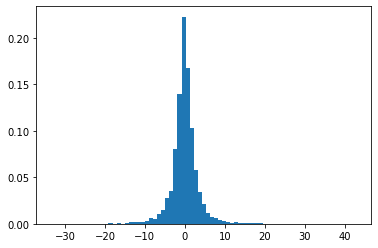

In [4]:
df['percentage_returns'] = df['returns'] * 100
df.dropna(inplace=True)

# RETURNS DISTRIBUTION 
plt.hist(df.percentage_returns,bins=75,density = True); # if density = True (percentage probability), False = frequency 

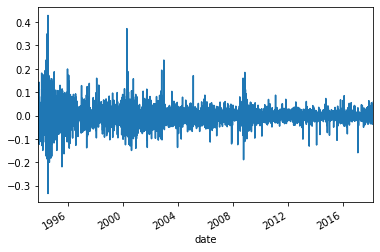

In [5]:
returns  = df['returns'].plot()

# Get Search Data from Google Trends
### Atempt 1
- terms consist of Activision games from:
    - wikipedia https://en.wikipedia.org/wiki/List_of_Activision_video_games
    - MobyGames https://www.mobygames.com/browse/games/activision-publishing-inc/
    
    ---------------------------
    
- Data has too many gaps to be useful, game names are poor features

In [8]:
# copied from csv to txt file
terms = open("terms_games.txt", "r") 
terms = terms.readlines()
terms_l = []
for t in terms:
    terms_l.append(t[:-1])
terms_l[:3]

['3D Ultra Mini Golf Adventures',
 'A Collection of Activision Classic Games for th...',
 'Aces of the Galaxy']

#### Similar Terms data is extremely spotty

C:\Users\09ale\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



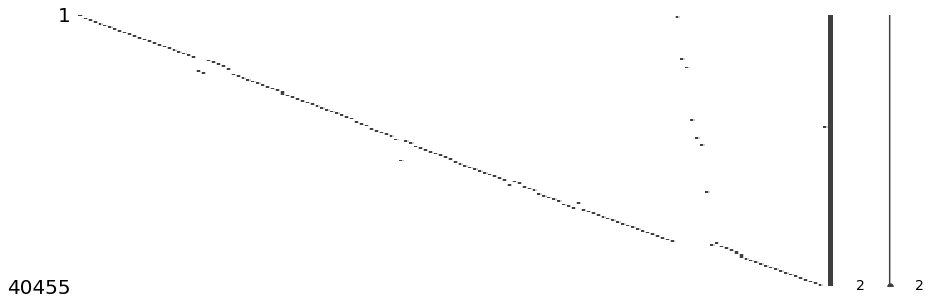

In [64]:
#Start with google trends
pytrend = TrendReq()

# can only look up 5 terms at a time, therefore requires an itterative process to get batches of terms
def batches(iterable, n=1):
    """
    Curtosy of https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
    - takes a list and parses it into batches according to n size 
    - returns separate chucks as list
    """
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
# builds a dataframe of search terms 
df_list = []
for x in batches(terms_l, 1):
    # Up to five terms in a list
    pytrend.build_payload(x,geo='US')
    try: 
        df = pytrend.interest_over_time()
    except: 
        pass
    df_list.append(df)

# Merge all batches into a single DF
df = pd.concat(df_list,axis=0)

# Data Completness
missingno.matrix(df,figsize=(15,5))

In [66]:
(df.notna().sum()/len(df)*100).sort_values(ascending=False)
# plt.hist((df.notna().sum()/len(df)*100))

isPartial                                 100.000000
Tony Hawk's Pro Skater 4                    1.290323
Ghostbusters II                             1.290323
Tony Hawk's Pro Skater                      1.290323
MechWarrior 2: Mercenaries                  0.645161
                                             ...    
SiN Gold                                    0.645161
SiN                                         0.645161
Shrek Forever After: The Final Chapter      0.645161
Shrek 2                                     0.645161
Aces of the Galaxy                          0.645161
Length: 153, dtype: float64

In [67]:
df.head()

df['Tenchu: Return from Darkness'].dropna()

date
2015-01-04     0.0
2015-01-11    69.0
2015-01-18    68.0
2015-01-25     0.0
2015-02-01     0.0
              ... 
2019-12-01     0.0
2019-12-08    44.0
2019-12-15     0.0
2019-12-22    51.0
2019-12-29     0.0
Name: Tenchu: Return from Darkness, Length: 261, dtype: float64

- virtually all features miss data
- perhaps games only popular during time of release and not subsequently 


###  Attempt 2
- Fix issue of gap in data caused by multuple terms 

In [15]:
def search_queries (word_list):
    #Start with google trends
    pytrend = TrendReq()
    # Up to five terms in a list
    #kw_list=["Tenchu: Return from Darkness"] #,'The Three Stooges']
    pytrend.build_payload(word_list,geo='US')
    df = pytrend.interest_over_time()
    return df

In [17]:
# copied from csv to txt file
terms = open("terms_games.txt", "r") 
terms = terms.readlines()
terms_l = []
for t in terms:
    terms_l.append(t[:-1])
terms_l[:3]


['3D Ultra Mini Golf Adventures',
 'A Collection of Activision Classic Games for th...',
 'Aces of the Galaxy']

In [26]:

q = []
for w in terms_l[:2]:
    print([w])
    
#     q.append(search_queries([w]))
# q


['3D Ultra Mini Golf Adventures']
['A Collection of Activision Classic Games for th...']


In [33]:
a

,Aces of the Galaxy,isPartial
date,,
2015-01-04,0,False
2015-01-11,0,False
2015-01-18,0,False
2015-01-25,0,False
2015-02-01,87,False
...,...,...
2019-12-01,0,False
2019-12-08,0,False
2019-12-15,0,False


In [ ]:
df = pd.concat(q,axis=1)

#### 1 term
- all data must be preserved

SIZE 522


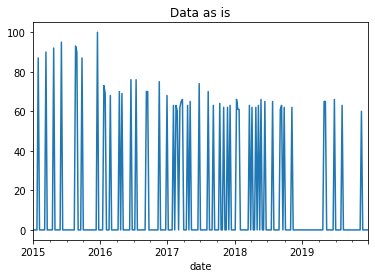

SIZE 106


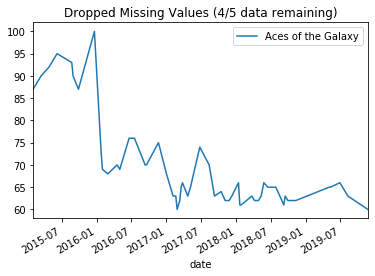

SIZE 522


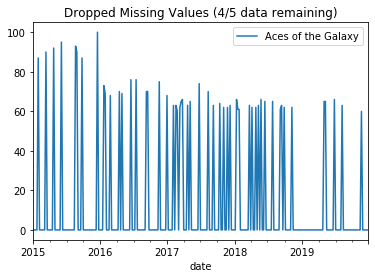

In [74]:
a = search_queries(['Aces of the Galaxy'])

a['Aces of the Galaxy'].plot()
print('SIZE',a.size)
plt.title('Data as is')
plt.show()

# dropped all rows that have value of 0 
# droped all rows with NaNs #
a.where(a['Aces of the Galaxy'] > 0 ).dropna().plot()
print('SIZE',a.where(a['Aces of the Galaxy'] > 0 ).dropna().size)
plt.title('Dropped Missing Values (4/5 data remaining)')
plt.show()

a.ffill().plot()
print('SIZE',a.ffill().size)
plt.title('Backfilled missing vals')
plt.show()

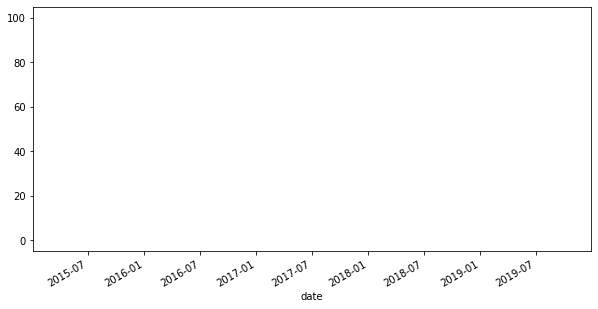

In [68]:
df['Tenchu: Return from Darkness'].plot(figsize = (10,5))

In [69]:
(df.notna().sum()/len(df)*100).sort_values(ascending=False)

isPartial                                 100.000000
Tony Hawk's Pro Skater 4                    1.290323
Ghostbusters II                             1.290323
Tony Hawk's Pro Skater                      1.290323
MechWarrior 2: Mercenaries                  0.645161
                                             ...    
SiN Gold                                    0.645161
SiN                                         0.645161
Shrek Forever After: The Final Chapter      0.645161
Shrek 2                                     0.645161
Aces of the Galaxy                          0.645161
Length: 153, dtype: float64

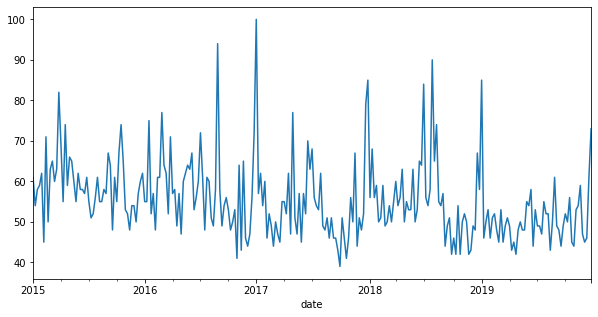

In [60]:
df['The Three Stooges'].plot(figsize = (10,5))

In [249]:
### Create Index of top Correlated Terms 